In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms

In [94]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [95]:
class CustomDataset():
    
    def __init__(self,filepath,transform=None):
        self.data = pd.read_csv(filepath)
        self.images = np.array(self.data.iloc[:,1:]).reshape((-1,1,28,28))/255.
        self.labels = np.array(self.data.iloc[:,0])
        self.transform = transform
        
    def __getitem__(self,index):
        image = self.images[index]
        #print image.shape
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image,label
        
    def __len__(self):
        return (self.data.shape[0])

In [96]:
img, lab = CustomDataset('./mnist_fashion/train_dataset.csv',transform =None).__getitem__(0)
print (img.shape)

(1, 28, 28)


In [97]:
train_loader = DataLoader(CustomDataset('./mnist_fashion/train_dataset.csv',transform = None),
                         batch_size=64,
                         shuffle=True)
valid_loader = DataLoader(CustomDataset('./mnist_fashion/valid_dataset.csv',transform = None),
                         batch_size=64,
                         shuffle=True)

test_loader = DataLoader(CustomDataset('./mnist_fashion/fashion-mnist_test.csv',transform = None),
                         batch_size=64,
                         shuffle=True)

In [98]:
for i,j in train_loader:
    print i.shape
    break

torch.Size([64, 1, 28, 28])


In [99]:
train_loader.dataset.images.shape

(48000, 1, 28, 28)

In [100]:
data_loaders = {"train": train_loader, "val": valid_loader}
data_lengths = {"train": train_loader.dataset.data.shape[0], "val": train_loader.dataset.data.shape[0]}

<img src="mnist_fashion/CNN-example-block-diagram.jpg">

<http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/>

In [113]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        # define all the components that will be used in the NN (these can be reused)
        self.layer1 = nn.Sequential(
                    nn.Conv2d(1,32,kernel_size=5, stride=1, padding=2),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                    nn.Conv2d(32,64,kernel_size=5, stride=1, padding=2),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(7*7*64,1000)
        self.fc2 = nn.Linear(1000,10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [114]:
cnn = CNN()
print cnn

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
)


In [115]:
cnn.parameters

<bound method CNN.parameters of CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
)>

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [117]:
num_epoch =10
train_losses = []
valid_losses = []
for epoch in range( num_epoch):
    
    print('Epoch {}/{}'.format(epoch, num_epoch- 1))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            cnn.train() # Set model to training mode
        else:
            cnn.eval() # Set model to evaluate mode
        
        running_loss = 0.0
        # Iterate over data.
        for i, (images,labels) in enumerate(data_loaders[phase]):
            # torch can only train on Variable, so convert them to Variable

            images = Variable(images.float())
            labels = Variable(labels)

            outputs = cnn(images) # Forward pass: compute the output class given a image
            loss = criterion(outputs,labels) # Compute the loss: difference between the output class and the pre-given label
            
            optimizer.zero_grad() # clear gradients for next train
            if phase == 'train':
                loss.backward() # backpropagation, compute gradients
                optimizer.step() # apply gradients  and update the weights of hidden nodes
                
            running_loss += loss.data * images.size(0)
            
            if phase == 'train':
                if (i+1) % 100 == 0 :
                    print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, i+1, data_lengths[phase]//64, loss.data))
                    
        epoch_loss = running_loss / data_lengths[phase]
        if phase =='train':
            train_losses.append(epoch_loss)
        if phase =='val':
            valid_losses.append(epoch_loss)
        print('Epoch [{}/{}]{} Loss: {:.4f}'.format(epoch+1, num_epoch,phase, epoch_loss))    

Epoch 0/9
----------
Epoch [1/10], Step [100/750], Loss: 0.7816
Epoch [1/10], Step [200/750], Loss: 0.2435
Epoch [1/10], Step [300/750], Loss: 0.4464
Epoch [1/10], Step [400/750], Loss: 0.2598
Epoch [1/10], Step [500/750], Loss: 0.5166
Epoch [1/10], Step [600/750], Loss: 0.3028
Epoch [1/10], Step [700/750], Loss: 0.3659
Epoch [1/10]train Loss: 0.4524
Epoch [1/10]val Loss: 0.0863
Epoch 1/9
----------
Epoch [2/10], Step [100/750], Loss: 0.3074
Epoch [2/10], Step [200/750], Loss: 0.3698
Epoch [2/10], Step [300/750], Loss: 0.4256
Epoch [2/10], Step [400/750], Loss: 0.3418
Epoch [2/10], Step [500/750], Loss: 0.2252
Epoch [2/10], Step [600/750], Loss: 0.2617
Epoch [2/10], Step [700/750], Loss: 0.1898
Epoch [2/10]train Loss: 0.2820
Epoch [2/10]val Loss: 0.0671
Epoch 2/9
----------
Epoch [3/10], Step [100/750], Loss: 0.1929
Epoch [3/10], Step [200/750], Loss: 0.1419
Epoch [3/10], Step [300/750], Loss: 0.1900
Epoch [3/10], Step [400/750], Loss: 0.2374
Epoch [3/10], Step [500/750], Loss: 0.3358


In [118]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 92.0000 %


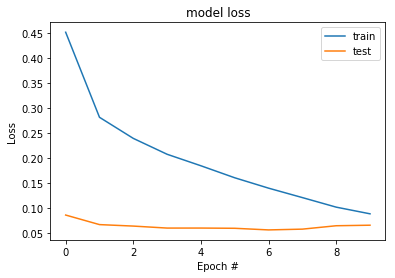

In [119]:
#losses_in_epochs = losses[:]
#plt.xkcd()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('model loss')
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(['train', 'test'], loc='upper right')
plt.show()